Задание **Lite** - **Рекуррентные нейронные сети и одномерные свёрточные сети для обработки текстов**

Напишите классификацию заболеваний по базе симптомов, используя любые подходы, связанные с обработкой текстов.

1. Embedding + LSTM сеть.
2. Embedding + Conv1D сеть.
3. Embedding + сложная сеть из Dense, LSTM и Conv1D.

Добейтесь максимальной точности распознавания.

Используйте xLen = 50.

**Так как экспериментов много для удобства проверки сделал ячейки кода так чтобы можно было их свернуть.**


**В конце будет сравнительная таблица для удобного просмотра результатов.**

# Общая подготовка

## Подключение библиотек

In [ ]:
from google.colab import files #модуль для загрузки файлов в colab
import numpy as np #библиотека для работы с массивами данных
import pandas as pd #библиотека для обработки и анализа данных
import matplotlib.pyplot as plt #библиотека для визуализации данных
# "Магическая"команда python для запуска библиотеки в ноутбуке
%matplotlib inline

from tensorflow.keras import utils #модуль с утилитами кераса, будем использовать для вызова метода преобразования категорий в вектора
from tensorflow.keras.models import Sequential #последовательная модель нейросети кераса
# Загружаем стандартные слои нейросети(полносвязный, регуляризации, нормализации, векторного представления слов, выравнивания, активации)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# Загружаем сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# Загружаем рекуррентные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
# Загружаем алгоритмы обучения/оптимизации
from tensorflow.keras.optimizers import Adam, RMSprop

from keras.preprocessing.text import Tokenizer, text_to_word_sequence #инструменты предобработки текста от кераса
from sklearn.model_selection import train_test_split #модуль для разбиения данных на обучающую и тестовую выборки
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import os
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Подготовка данных 

In [ ]:
# Создадим функцию для чтения файла с возратом нового файла без переноса на следующую строку
def readtext(fileName):
  file = open(fileName, 'r')
  text = file.read()
  text = text.replace('\n', ' ')
  file.close()
  return text

In [ ]:
# Определим классы болезней. Всего 9 заболеваний.
className = ['Аппендицит', 'Гастрит', 'Гепатит', 'Дуоденит', 'Колит', 'Панкреатит', 'Эзофагит', 'Энтерит', 'Язва']

# И их кол-во
nClasses = len(className)
print("Всего болезней:",nClasses)

Всего болезней: 9


In [ ]:
# Создадим пустой список в котором будут все болезни
Diseases = []

In [ ]:
# Добавим в этот список 
# Пройдемся циклом для его заполнения. Файлы лежат на гугл диске.
for i in className:
  for j in os.listdir('/content/drive/MyDrive/База болезни_общая/'):
    if i in j:
      Diseases.append(readtext('/content/drive/MyDrive/База болезни_общая/' + j))
      print(j, 'добавлен в общую выборку')

Аппендицит.txt добавлен в общую выборку
Гастрит.txt добавлен в общую выборку
Гепатит.txt добавлен в общую выборку
Дуоденит.txt добавлен в общую выборку
Колит.txt добавлен в общую выборку
Панкреатит.txt добавлен в общую выборку
Эзофагит.txt добавлен в общую выборку
Энтерит.txt добавлен в общую выборку
Язва.txt добавлен в общую выборку


In [ ]:
# Все болезни в одном списке (список списков)
print('Общее кол-во болезней в списке Diseases:', len(Diseases))

Общее кол-во болезней в списке Diseases: 9


In [ ]:
# Пример одной из болезней в общем списке
print(Diseases[8])  # Язва

боль, часто локализованная в эпигастрии и уменьшающаяся после еды или антацидов.  боль описывается как жгучая или грызущая, иногда как чувство голода.  Боль в эпигастральной области кислая отрыжка  изжога снижение массы тела рвота и тошнота после еды  боль после еды и в зависимости от пораженного отдела может появиться сразу или спустя 1–2 часа рвота кислым содержимым желудка  боль в животе Боль возникает в середине живота («под ложечкой»), никуда, как правило, не отдает Болевой синдром. Возникает в верхней части живота, носит непостоянный характер.  Изжога Рвота тошнота Отсутствие аппетита  жжениеи  боль в верхней части живота выше пупка тошнота рвота снижение аппетита снижение веса слабость усталость  налет на языке метеоризм чередование поноса ,запора и нормального стула неприятный запах из ротовой полости уменьшение веса тошнота рвота изжога и отрыжка кислотой  Ноющие или схваткообразные боли, слабоинтенсивные в эпигастральной области, чаще возникают натощак или непосредственно пос

In [ ]:
# Создадим 2 пустых списка (обучающий и тестовый), для последующего заполнения
trainText = []
testText = []

In [ ]:
# С помощью функции train_test_split в цикле разделим выборки (на обучающую и тестовую). Тестовая будет 20% от общего текста.
# Так как у нас описание болезней предоставленно в виде строк, то сначала каждую болезнь из строки привратиv в список, 
# shuffle = False. Чтобы слова не перемешивались и был смысл фраз.
# После превратим в строку и добавим в обучающие и тестовые списки. 

for i in range(nClasses):
  train, test = train_test_split(Diseases[i].split(" "), test_size=0.2, shuffle=False)
  train = " ".join(train)
  test = " ".join(test)
  trainText.append(train)
  testText.append(test)

In [ ]:
# Получилось два списка Обучающая(80%) и Тестовая(20%) от общего описания заболеваний.

In [ ]:
# Как пример посмотрим первую болезнь.
print(len(Diseases[0]))
print(len(trainText[0]))
print(len(testText[0]))

# Да, получилось 80 на 20. 

4076
3258
817


In [ ]:
# Посмотрим какая получилось длина списков
print(len(trainText))
print(len(testText))

# Все верно, 9 заболеваний.

9
9


In [ ]:
# Примеры получившихся выборок обучающей и тестовой.
print('Обучающая Колит:')
print(trainText[4])
print()
print('Тестовая Эзофагит:')
print(testText[6])

Обучающая Колит:
постоянные позывы на дефекацию, урчание, вздутие живота, профузный понос, иногда с кровью и слизью, резкие боли в животе переполнение и тяжесть в брюшной полости,  чувство сдавливания. Боли схваткообразные (колики), которые сопровождаются позывами к дефекаци   Геморрагическая диарея различной выраженности и продолжительности позывы на дефекацию,  неинтенсивная схваткообразная боль внизу живота,  примеси крови и слизи в стуле.   боль в животе диарея выделение крови из прямой кишки (гематохезия) повышение температуры тела тахикардия слабость утомляемость внекишечные проявления – поражение суставов, глаз, печени и желчевыводящих путей, полости рта.  дискомфортные ощущения в животе тупые боли в желудке,которые усиливаются при беге или ходьбе проблемы со стулом - диареи или запоры выделяемые каловые массы содержат слизистые прожилки или примеси крови ложные позывы к дефекации тяжесть в животе вздутие метеоризм  постоянные проблемы со стулом повышенное газообразование вздути

## Обработка данных

In [ ]:
# Преобразуем тектовые данные в числовые

# Зададим масимальное число индексов для обучения
maxWordsCount = 10000

# Токинизируем тескт на основе обучающей выборки
tokenizer = Tokenizer (num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', char_level=False, oov_token='unknow')

tokenizer.fit_on_texts(trainText)

In [ ]:
# Преобразововаем текст в последовательность индексов согласно словарю 
trainWordIndexes = tokenizer.texts_to_sequences(trainText)   # Создаем обучающий набор
testWordIndexes = tokenizer.texts_to_sequences(testText)     # И тестовый набор

## Общая статистика


In [ ]:
print ("Статистика по обучающим текстам:\n")
sum_char = 0
sum_words = 0 

for i in range(nClasses):
  print (className[i], ' ', len(trainText[i]), "символов," , len(trainWordIndexes[i]), " слов")

for i in range(nClasses):  
  sum_char += len(trainText[i]) 
  sum_words += len(trainWordIndexes[i])
print ("\nВ сумме ", sum_char, " символов  и  ", sum_words, " слов")

print ("\n\n")
print ("Статистика по тестовым текстам:\n")
sum_char = 0
sum_words = 0 

for i in range(nClasses):
  print (className[i], ' ', len(testText[i]), "символов," , len(testWordIndexes[i]), " слов")

for i in range(nClasses):  
  sum_char += len(testText[i]) 
  sum_words += len(testWordIndexes[i])
print ("\nВ сумме ", sum_char, " символов  и ", sum_words, " слов")


Статистика по обучающим текстам:

Аппендицит   3258 символов, 471  слов
Гастрит   5440 символов, 660  слов
Гепатит   4385 символов, 555  слов
Дуоденит   3186 символов, 393  слов
Колит   7262 символов, 950  слов
Панкреатит   9217 символов, 1183  слов
Эзофагит   4647 символов, 639  слов
Энтерит   5151 символов, 662  слов
Язва   2733 символов, 377  слов

В сумме  45279  символов  и   5890  слов



Статистика по тестовым текстам:

Аппендицит   817 символов, 108  слов
Гастрит   1276 символов, 179  слов
Гепатит   1137 символов, 132  слов
Дуоденит   754 символов, 95  слов
Колит   1864 символов, 242  слов
Панкреатит   2095 символов, 297  слов
Эзофагит   1219 символов, 154  слов
Энтерит   1231 символов, 166  слов
Язва   727 символов, 95  слов

В сумме  11120  символов  и  1468  слов


## Функции для создания выборок: обучающей и проверочной

In [ ]:
# Для этого создадим несколько вспомогательных функций

# Функция для разделения на короткие векторы
def getSetFromIndexes (wordIndexes, xLen, step):      
  xSample = []                                       
  wordsLen = len(wordIndexes)                       
  index = 0                                           


  while (index + xLen <= wordsLen):                     
    xSample.append(wordIndexes[index:index + xLen])   
    index += step                                    

  return xSample

In [ ]:
# Функция для формирования обучающей и проверочной выборок
def createSetsMultiClasses(wordIndexes, xLen, step):

  # Создаем выборки из индексов для каждого из 6 классов
  nClasses = len(wordIndexes)
  classesXSamples = []
  for i in wordIndexes:
    classesXSamples.append(getSetFromIndexes(i,xLen,step))

  # Один общий список
  xSamples = []
  ySamples = []

  for t in range(nClasses):                               # В нашем случаи цикл от 0 до 6 (кол-во классов)
    xT = classesXSamples[t]                                # На каждой итерации цикла берем очередной нарезанный текст одного из класса

    for i in range (len(xT)):                             # Циклом проходимся по каждому его окну
      xSamples.append(xT[i])                              # Добавляем в общий список обучающей выборке
      ySamples.append(utils.to_categorical(t, nClasses))  # И соответствующий вектор класса

    # Первод в массив numpy
  xSamples = np.array(xSamples)                           
  ySamples = np.array(ySamples)    


  return (xSamples, ySamples)

## Подготовка данных

In [ ]:
# Зададим базовые параметры 
xLen = 50   # Ширина окна
step = 5    # Шаг разбиения

In [ ]:
# Формирование обучающей и тестовой выборок
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step) 

In [ ]:
# Посмотрим на размер всех данных
print('xTrain: ', xTrain.shape)
print('yTrain: ', yTrain.shape)
print('xTest: ' , xTest.shape)
print('yTest: ', yTest.shape)

xTrain:  (1094, 50)
yTrain:  (1094, 9)
xTest:  (209, 50)
yTest:  (209, 9)


## Функции для распознавания проверочной выборки

In [ ]:
# Переведем тестовую выборку в удобные для распознавания размеры

def createTestMultiClasses (wordIndexes, xLen, step):
  nClasses = len(wordIndexes) 
  xTest9ClassesBow = []               
  xTest9Classes = []                 
  for wI in wordIndexes:             
    sample = (getSetFromIndexes(wI, xLen, step)) 
    xTest9Classes.append(np.array(sample))       
    xTest9Classes01.append(tokenizer.sequences_to_matrix(sample)) 
  xTest9Classes01 = np.array(xTest9Classes01)        
  
  return xTest9ClassesBow, xTest9Classes 

In [ ]:
# Создадим функцию которая будет представлять выборку в удобном для распознавания размерах

def createTestMultiClasses(wordIndexes, xLen, step):

  nClasses = len(wordIndexes)                                             
  xTest9ClassesBow = []                                                   
  xTest9Classec = []                                                      

  # Пройдемся циклом по каждому тестовому тексту из последовательности индексов
  for i in wordIndexes:
    sample = (getSetFromIndexes(i,xLen, step))                            
    xTest9Classec.append(sample)                                          
    xTest9ClassesBow.append(tokenizer.sequences_to_matrix(sample))        
  
  xTest9ClassesBow = np.array(xTest9ClassesBow)                           
  xTest9Classec = np.array(xTest9Classec)                                

  return xTest9ClassesBow, xTest9Classec

In [ ]:
# Подгоним форму тестовых классов под функцию recognizeMultiClass.
# Для BOW тоже понадобится. Сразу создадим и для этих экспериментов.

xTest9ClassesBow, xTest9Classes = createTestMultiClasses(testWordIndexes, xLen, step)

**Немного переделал следующую функцию, чтобы она возвращала средний процент распознавания для каждой болезни и общий процент. Чтобы эти данные можно занести в таблицу**

In [ ]:
# Функция для распознавания тестовой выборки и вывод результата
def recognizeMultiClass(model, xTest, modelName):

  print("Нейронная сеть: ", modelName)
  print()

  val = []
  pred = []
  totalSumRec = []

  # Циклом прохоим по всем классам
  for i in range(nClasses):
    currPred = model.predict(xTest[i])    # Получение результата распознавания класса по блокам слов длинной xLen
    pred.append(currPred)
    currOut = np.argmax(currPred, axis=1)

    # Подсчет процента распознавания каждого класса

    evVal = []
    sumRec = []

    for j in range(nClasses):
      sumRec.append(0)
      for t in range(len(currOut)):
        if (currOut[t] == j):
          sumRec[j] += 1
      evVal.append(sumRec[j] / len(currOut))

    totalSumRec.append(sumRec[i])

    # Определение какой класс за какой был распознан
    val.append(evVal[i])
    recognizedClass = np.argmax(evVal)

    # Вывод результата распознавания по текущему классу
    isRecognized = "распознано НЕ ВЕРНО!"
    if (recognizedClass == i):
      isRecognized = "распознано ВЕРНО!"
    print(className[i], " распознано ", int(100*evVal[i]), "% сеть считает, что это ", className[recognizedClass], ", ", isRecognized)

  # Вывод среднего процента по всем классам
  print()
  sumVal = 0
  sumCount = 0
  lenXtest = []
    
  for i in range(nClasses):
    sumCount += len(xTest[i])
    sumVal += totalSumRec[i]

  average = int(100*sumVal/sumCount)
  print("Средний процент распознавания ", average, "%")
  return val, average
  

## Функция: вывода summary и схемы нейронной сети и графика обучения

In [ ]:
# Функция вывода summary и схемы нейронной сети
def showModel(model):
  #model.summary()
  print ("\n\n")
  return plot_model(model, dpi=80, show_shapes=True)

In [ ]:
# Функция вывода графиков
def chart(hist):
  plt.figure(figsize=(10,5))
  plt.plot(hist.history['loss'], label = 'Доля ошибки  на обучающем наборе')
  plt.plot(hist.history['val_loss'], label = 'Доля ошибки на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля ошибки')
  plt.legend()
  plt.show()

  plt.figure(figsize=(10,5))
  plt.plot(hist.history['accuracy'], label = 'Доля верных ответов на обучающем наборе')
  plt.plot(hist.history['val_accuracy'], label = 'Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.show()

In [ ]:
# Функция для сохранения результата обучения. С последующей записью в таблицу pandas. 
def table(his):
  dct = []  
  # В цикле проходимся по всем значениям из history                                                  
  for v in his.history.values():                                        
    dct.append (v)                                            # Результат выгружаются в словарь.                                                                
  result = np.array(dct)                                      # Переводим в numpy массив. 
  return result

In [ ]:
# Создание таблицы pandas, c данными заголовками 
df = pd.DataFrame(columns = ['loss', 'accuracy', 'val_loss', 'val_accuracy', 'Аппендицит', 'Гастрит', 'Гепатит', 'Дуоденит', 'Колит', 'Панкреатит', 'Эзофагит', 'Энтерит', 'Язва', 'Средний процент распознавания'])

# Эксперименты

## 1. Серия экспериментов Embedding + LSTM сеть

### 1.1 LSTM(4)

In [ ]:
modelLSTM_4 = Sequential()

modelLSTM_4.add(Embedding(maxWordsCount, 50, input_length=xLen))
modelLSTM_4.add(SpatialDropout1D(0.5))
modelLSTM_4.add(BatchNormalization())

modelLSTM_4.add(LSTM(4))
modelLSTM_4.add(Dense(9,activation='softmax'))

modelLSTM_4.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#### Схема нейронной сети

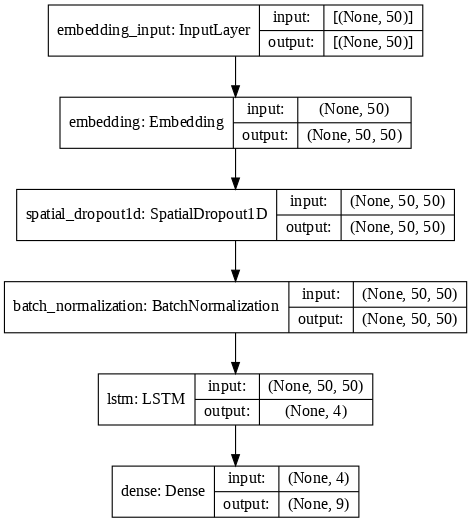

In [ ]:
showModel(modelLSTM_4)

#### Обучение

In [ ]:
# Обучаем нейронную сеть
historyLSTM_4 = modelLSTM_4.fit(xTrain, yTrain, epochs=50, batch_size = 20, validation_data=(xTest, yTest))

Epoch 1/50
55/55 [==============================] - 3s 16ms/step - loss: 2.2012 - accuracy: 0.1199 - val_loss: 2.1652 - val_accuracy: 0.2344
Epoch 2/50
55/55 [==============================] - 0s 8ms/step - loss: 2.1107 - accuracy: 0.2324 - val_loss: 2.1430 - val_accuracy: 0.2344
Epoch 3/50
55/55 [==============================] - 0s 9ms/step - loss: 2.0369 - accuracy: 0.2801 - val_loss: 2.1196 - val_accuracy: 0.2297
Epoch 4/50
55/55 [==============================] - 0s 9ms/step - loss: 1.9532 - accuracy: 0.3773 - val_loss: 2.0861 - val_accuracy: 0.2010
Epoch 5/50
55/55 [==============================] - 0s 9ms/step - loss: 1.8137 - accuracy: 0.4434 - val_loss: 2.1206 - val_accuracy: 0.1483
Epoch 6/50
55/55 [==============================] - 0s 9ms/step - loss: 1.6351 - accuracy: 0.5441 - val_loss: 2.1472 - val_accuracy: 0.1722
Epoch 7/50
55/55 [==============================] - 0s 9ms/step - loss: 1.4666 - accuracy: 0.5986 - val_loss: 2.0740 - val_accuracy: 0.2632
Epoch 8/50
55/55 [=

In [ ]:
# Сохраняем веса
modelLSTM_4.save_weights('modelLSTM_4 loss: 0.2204 - val_accuracy: 0.6364.h5')  

#### График и средний процент

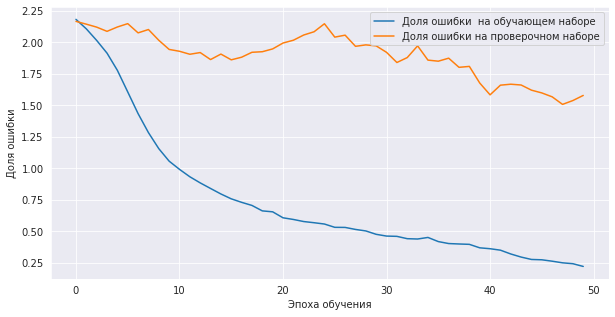

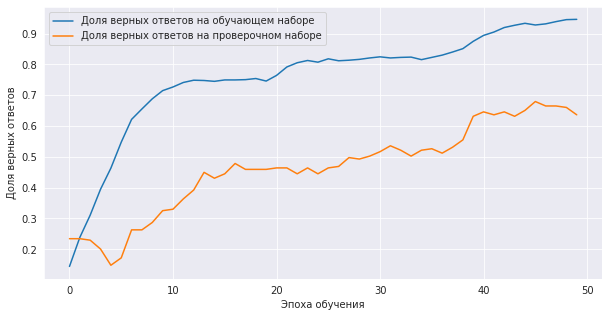

In [ ]:
# Выводим график
chart(historyLSTM_4)

In [ ]:
# Посмотрим на результат на тестовой выборке
val, average = recognizeMultiClass(modelLSTM_4, xTest9Classes, "modelLSTM_4")

Нейронная сеть:  modelLSTM_4

Аппендицит  распознано  91 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  0 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Гепатит  распознано  94 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  30 % сеть считает, что это  Эзофагит ,  распознано НЕ ВЕРНО!
Колит  распознано  89 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  66 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Эзофагит  распознано  66 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  87 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  0 % сеть считает, что это  Аппендицит ,  распознано НЕ ВЕРНО!

Средний процент распознавания  63 %


In [ ]:
# C помощью функции получаем значения на последней эпохе
result = table(historyLSTM_4)    

In [ ]:
# Заносим результат в таблицу
df.loc['1.1 LSTM'] = [round(result[0][-1],4), round(result[1][-1]*100, 4), round(result[2][-1],4), round(result[3][-1]*100,4),
                                          int(val[0]*100), int(val[1]*100), int(val[2]*100), int(val[3]*100), int(val[4]*100), int(val[5]*100), int(val[6]*100), int(val[7]*100), int(val[8]*100), average]

### 1.2 LSTM(20)

In [ ]:
modelLSTM_20 = Sequential()

modelLSTM_20.add(Embedding(maxWordsCount, 50, input_length=xLen))
modelLSTM_20.add(SpatialDropout1D(0.5))
modelLSTM_20.add(BatchNormalization())

modelLSTM_20.add(LSTM(20))
modelLSTM_20.add(Dense(9,activation='softmax'))

modelLSTM_20.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#### Схема нейронной сети

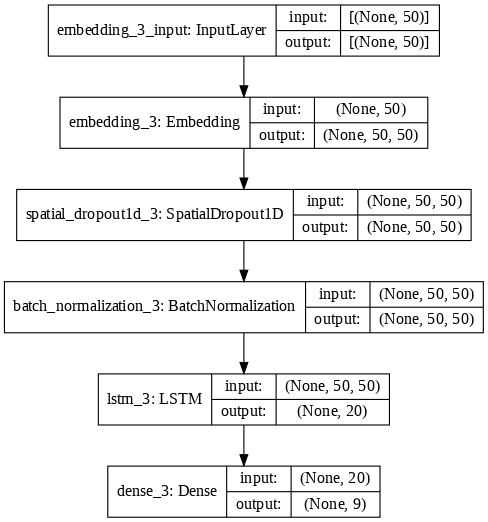

In [ ]:
showModel(modelLSTM_20)

#### Обучение

In [ ]:
# Обучаем нейронную сеть
history_LSTM_20 = modelLSTM_20.fit(xTrain, yTrain, epochs=50, batch_size = 20, validation_data=(xTest, yTest))

Epoch 1/50
55/55 [==============================] - 3s 17ms/step - loss: 2.1729 - accuracy: 0.1750 - val_loss: 2.1071 - val_accuracy: 0.2392
Epoch 2/50
55/55 [==============================] - 0s 9ms/step - loss: 1.8631 - accuracy: 0.3744 - val_loss: 2.4131 - val_accuracy: 0.2392
Epoch 3/50
55/55 [==============================] - 0s 9ms/step - loss: 1.4085 - accuracy: 0.5626 - val_loss: 2.0976 - val_accuracy: 0.2823
Epoch 4/50
55/55 [==============================] - 0s 9ms/step - loss: 1.0060 - accuracy: 0.7336 - val_loss: 2.3506 - val_accuracy: 0.2967
Epoch 5/50
55/55 [==============================] - 0s 9ms/step - loss: 0.7393 - accuracy: 0.8305 - val_loss: 2.9075 - val_accuracy: 0.2823
Epoch 6/50
55/55 [==============================] - 0s 8ms/step - loss: 0.6049 - accuracy: 0.8499 - val_loss: 2.5434 - val_accuracy: 0.3445
Epoch 7/50
55/55 [==============================] - 0s 9ms/step - loss: 0.4629 - accuracy: 0.8738 - val_loss: 2.9402 - val_accuracy: 0.3732
Epoch 8/50
55/55 [=

#### График и средний процент

In [ ]:
# Сохраняем веса
modelLSTM_20.save_weights('modelLSTM_20 loss: 0.0143   - val_accuracy: 0.5311.h5')   

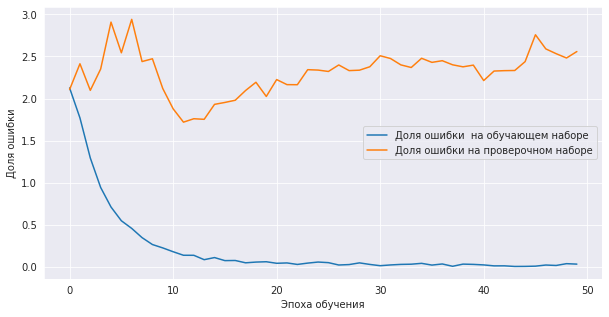

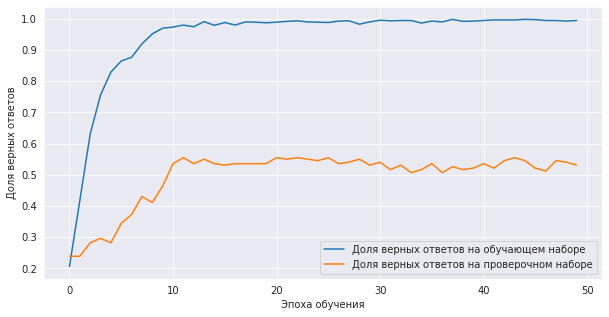

In [ ]:
# Выводим график
chart(history_LSTM_20)

In [ ]:
# Посмотрим на результат на тестовой выборке
val, average = recognizeMultiClass(modelLSTM_20, xTest9Classes, "modelLSTM_4")

Нейронная сеть:  modelLSTM_4

Аппендицит  распознано  100 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  11 % сеть считает, что это  Дуоденит ,  распознано НЕ ВЕРНО!
Гепатит  распознано  82 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  40 % сеть считает, что это  Гастрит ,  распознано НЕ ВЕРНО!
Колит  распознано  97 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  8 % сеть считает, что это  Гепатит ,  распознано НЕ ВЕРНО!
Эзофагит  распознано  57 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  100 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  0 % сеть считает, что это  Дуоденит ,  распознано НЕ ВЕРНО!

Средний процент распознавания  53 %


In [ ]:
# C помощью функции получаем значения на последней эпохе
result = table(history_LSTM_20)    

In [ ]:
# Заносим результат в таблицу
df.loc['1.2 LSTM'] = [round(result[0][-1],4), round(result[1][-1]*100, 4), round(result[2][-1],4), round(result[3][-1]*100,4),
                                          int(val[0]*100), int(val[1]*100), int(val[2]*100), int(val[3]*100), int(val[4]*100), int(val[5]*100), int(val[6]*100), int(val[7]*100), int(val[8]*100), average]

### 1.3 LSTM(4 , return_sequences=True), LSTM(4)

In [ ]:
model_LSTM_4_True_LSTM_4 = Sequential()

model_LSTM_4_True_LSTM_4.add(Embedding(maxWordsCount, 50, input_length=xLen))

model_LSTM_4_True_LSTM_4.add(SpatialDropout1D(0.5))
model_LSTM_4_True_LSTM_4.add(BatchNormalization())
model_LSTM_4_True_LSTM_4.add(LSTM(4, return_sequences=True))
model_LSTM_4_True_LSTM_4.add(LSTM(4))
model_LSTM_4_True_LSTM_4.add(Dense(9, activation='softmax'))

model_LSTM_4_True_LSTM_4.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#### Схема нейронной сети

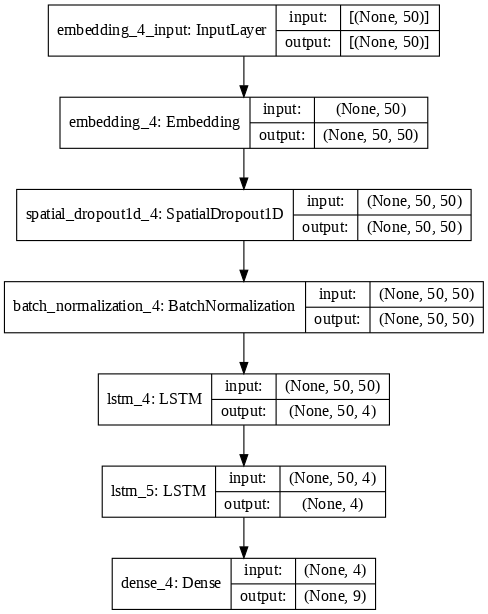

In [ ]:
showModel(model_LSTM_4_True_LSTM_4)

#### Обучение

In [ ]:
# Обучаем нейронную сеть
history_model_LSTM_4_True_LSTM_4 = model_LSTM_4_True_LSTM_4.fit(xTrain, yTrain, epochs = 50, batch_size = 20, validation_data=(xTest, yTest))

Epoch 1/50
55/55 [==============================] - 4s 23ms/step - loss: 2.1547 - accuracy: 0.1882 - val_loss: 2.1337 - val_accuracy: 0.2536
Epoch 2/50
55/55 [==============================] - 1s 11ms/step - loss: 1.9772 - accuracy: 0.3625 - val_loss: 2.0276 - val_accuracy: 0.3301
Epoch 3/50
55/55 [==============================] - 1s 11ms/step - loss: 1.7416 - accuracy: 0.4764 - val_loss: 2.1935 - val_accuracy: 0.2153
Epoch 4/50
55/55 [==============================] - 1s 11ms/step - loss: 1.5860 - accuracy: 0.5143 - val_loss: 2.1290 - val_accuracy: 0.2584
Epoch 5/50
55/55 [==============================] - 1s 11ms/step - loss: 1.4958 - accuracy: 0.5344 - val_loss: 1.9992 - val_accuracy: 0.3014
Epoch 6/50
55/55 [==============================] - 1s 11ms/step - loss: 1.4072 - accuracy: 0.5724 - val_loss: 2.0532 - val_accuracy: 0.3062
Epoch 7/50
55/55 [==============================] - 1s 11ms/step - loss: 1.3276 - accuracy: 0.5817 - val_loss: 1.9381 - val_accuracy: 0.3541
Epoch 8/50
55

In [ ]:
# Сохраняем веса
model_LSTM_4_True_LSTM_4.save_weights('model_LSTM_4_True_LSTM_4 loss: 0.0204 - val_accuracy: 0.5789.h5')   

#### График и средний процент

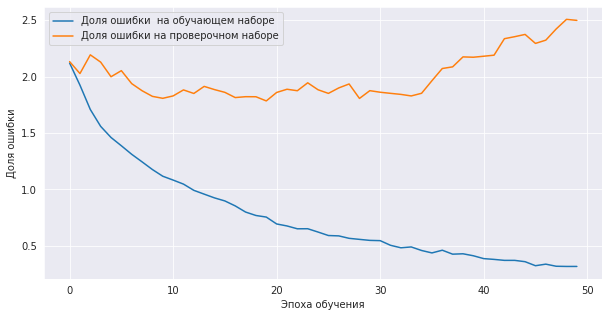

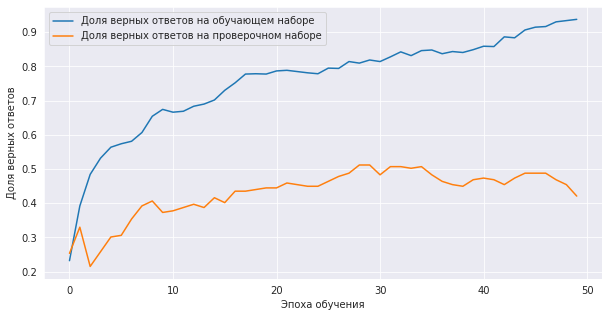

In [ ]:
# Выводим график
chart(history_model_LSTM_4_True_LSTM_4)

In [ ]:
# Посмотрим на результат на тестовой выборке
val, average = recognizeMultiClass(model_LSTM_4_True_LSTM_4, xTest9Classes, "model_LSTM_4_True_LSTM_4")

Нейронная сеть:  model_LSTM_4_True_LSTM_4

Аппендицит  распознано  0 % сеть считает, что это  Эзофагит ,  распознано НЕ ВЕРНО!
Гастрит  распознано  19 % сеть считает, что это  Дуоденит ,  распознано НЕ ВЕРНО!
Гепатит  распознано  88 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  100 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  41 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  24 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Эзофагит  распознано  66 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  66 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  0 % сеть считает, что это  Гастрит ,  распознано НЕ ВЕРНО!

Средний процент распознавания  42 %


In [ ]:
# C помощью функции получаем значения на последней эпохе
result = table(history_model_LSTM_4_True_LSTM_4)    

In [ ]:
# Заносим результат в таблицу
df.loc['1.3 LSTM'] = [round(result[0][-1],4), round(result[1][-1]*100, 4), round(result[2][-1],4), round(result[3][-1]*100,4),
                                          int(val[0]*100), int(val[1]*100), int(val[2]*100), int(val[3]*100), int(val[4]*100), int(val[5]*100), int(val[6]*100), int(val[7]*100), int(val[8]*100), average]

### 1.4 Bidirectional(LSTM(4 , return_sequences=True), LSTM(4))

In [ ]:
model_BD_LSTM_4_True_LSTM_4 = Sequential()

model_BD_LSTM_4_True_LSTM_4.add(Embedding(maxWordsCount, 50, input_length=xLen))

model_BD_LSTM_4_True_LSTM_4.add(SpatialDropout1D(0.5))
model_BD_LSTM_4_True_LSTM_4.add(BatchNormalization())
model_BD_LSTM_4_True_LSTM_4.add(Bidirectional(LSTM(4, return_sequences=True)))
model_BD_LSTM_4_True_LSTM_4.add(Bidirectional(LSTM(4)))
model_BD_LSTM_4_True_LSTM_4.add(Dropout(0.3))
model_BD_LSTM_4_True_LSTM_4.add(Dense(9, activation="softmax"))

model_BD_LSTM_4_True_LSTM_4.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#### Схема нейронной сети

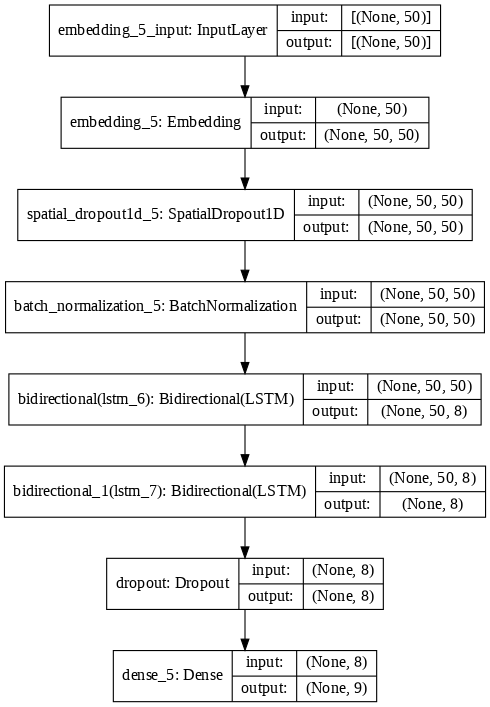

In [ ]:
showModel(model_BD_LSTM_4_True_LSTM_4)

#### Обучение

In [ ]:
# Обучаем нейронную сеть
history_model_BD_LSTM_4_True_LSTM_4 = model_BD_LSTM_4_True_LSTM_4.fit(xTrain, yTrain, epochs=50, batch_size=20, validation_data=(xTest, yTest))

Epoch 1/50
55/55 [==============================] - 7s 39ms/step - loss: 2.1565 - accuracy: 0.1819 - val_loss: 2.1446 - val_accuracy: 0.2392
Epoch 2/50
55/55 [==============================] - 1s 18ms/step - loss: 1.9260 - accuracy: 0.4263 - val_loss: 2.1152 - val_accuracy: 0.2392
Epoch 3/50
55/55 [==============================] - 1s 18ms/step - loss: 1.6599 - accuracy: 0.5610 - val_loss: 2.1187 - val_accuracy: 0.3158
Epoch 4/50
55/55 [==============================] - 1s 18ms/step - loss: 1.4165 - accuracy: 0.6322 - val_loss: 2.2391 - val_accuracy: 0.2344
Epoch 5/50
55/55 [==============================] - 1s 17ms/step - loss: 1.2641 - accuracy: 0.6512 - val_loss: 2.2144 - val_accuracy: 0.2679
Epoch 6/50
55/55 [==============================] - 1s 18ms/step - loss: 1.0958 - accuracy: 0.7216 - val_loss: 2.2502 - val_accuracy: 0.2440
Epoch 7/50
55/55 [==============================] - 1s 18ms/step - loss: 1.0254 - accuracy: 0.7258 - val_loss: 2.0821 - val_accuracy: 0.3062
Epoch 8/50
55

In [ ]:
# Сохраняем веса
model_BD_LSTM_4_True_LSTM_4.save_weights('model_BD_LSTM_4_True_LSTM_4 loss: 0.0204 - val_accuracy: 0.5789.h5')   

#### График и средний процент

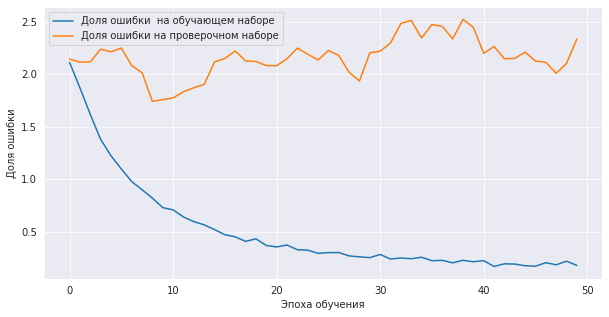

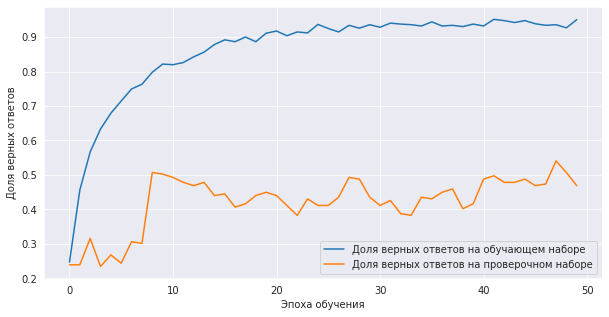

In [ ]:
# Выводим график
chart(history_model_BD_LSTM_4_True_LSTM_4)

In [ ]:
# Посмотрим на результат на тестовой выборке
val, average = recognizeMultiClass(model_BD_LSTM_4_True_LSTM_4, xTest9Classes, "BD_LSTM_4_True_LSTM_4")

Нейронная сеть:  BD_LSTM_4_True_LSTM_4

Аппендицит  распознано  83 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  19 % сеть считает, что это  Аппендицит ,  распознано НЕ ВЕРНО!
Гепатит  распознано  5 % сеть считает, что это  Колит ,  распознано НЕ ВЕРНО!
Дуоденит  распознано  50 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  84 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  22 % сеть считает, что это  Колит ,  распознано НЕ ВЕРНО!
Эзофагит  распознано  66 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  79 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  0 % сеть считает, что это  Гастрит ,  распознано НЕ ВЕРНО!

Средний процент распознавания  46 %


In [ ]:
# C помощью функции получаем значения на последней эпохе
result = table(history_model_BD_LSTM_4_True_LSTM_4)    

In [ ]:
# Заносим результат в таблицу
df.loc['1.4 LSTM'] = [round(result[0][-1],4), round(result[1][-1]*100, 4), round(result[2][-1],4), round(result[3][-1]*100,4),
                                          int(val[0]*100), int(val[1]*100), int(val[2]*100), int(val[3]*100), int(val[4]*100), int(val[5]*100), int(val[6]*100), int(val[7]*100), int(val[8]*100), average]

**Увеличение LSTM слоя не приводит к лучшим результатам. Попробуем сеть Embedding + Conv1D**

## 2. Серия экспериментов Embedding + Conv1D

### 2.1 Embedding + Conv1D(20,5),Conv1D(20,5)

In [ ]:
model_Conv1D_20_5 = Sequential()

model_Conv1D_20_5.add(Embedding(maxWordsCount, 50, input_length=xLen))

model_Conv1D_20_5.add(SpatialDropout1D(0.5))
model_Conv1D_20_5.add(BatchNormalization())
model_Conv1D_20_5.add(Conv1D(20, 5, activation='relu', padding='same'))
model_Conv1D_20_5.add(Conv1D(20, 5, activation='relu'))

model_Conv1D_20_5.add(MaxPooling1D(2))
model_Conv1D_20_5.add(Dropout(0.2))
model_Conv1D_20_5.add(BatchNormalization())
model_Conv1D_20_5.add(Flatten())

model_Conv1D_20_5.add(Dense(9, activation='softmax'))


model_Conv1D_20_5.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#### Схема нейронной сети

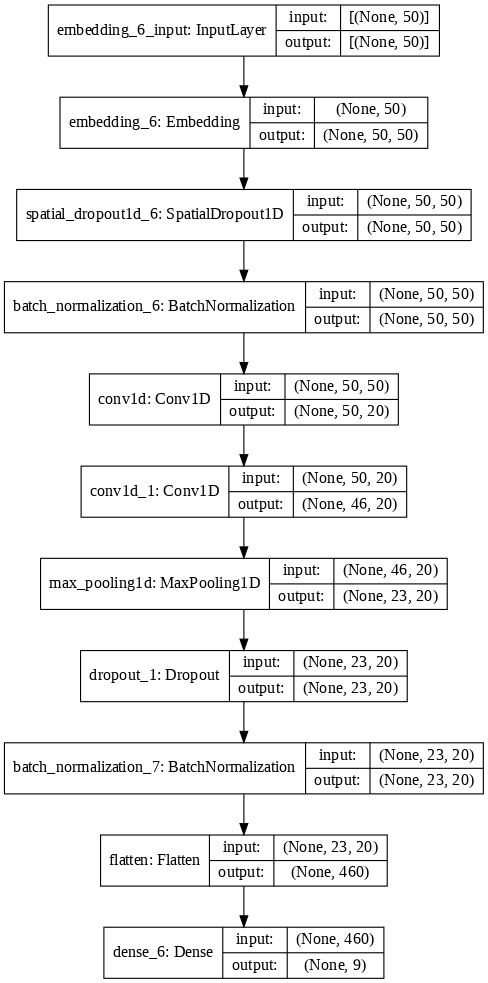

In [ ]:
showModel(model_Conv1D_20_5)

#### Обучение

In [ ]:
# Обучаем нейронную сеть
history_model_Conv1D_20_5 = model_Conv1D_20_5.fit(xTrain, yTrain, epochs = 50, batch_size=20, validation_data=(xTest, yTest))

Epoch 1/50
55/55 [==============================] - 2s 11ms/step - loss: 2.8301 - accuracy: 0.1145 - val_loss: 2.1830 - val_accuracy: 0.1148
Epoch 2/50
55/55 [==============================] - 0s 7ms/step - loss: 2.2048 - accuracy: 0.2456 - val_loss: 2.3404 - val_accuracy: 0.1148
Epoch 3/50
55/55 [==============================] - 0s 7ms/step - loss: 1.4800 - accuracy: 0.4855 - val_loss: 2.7073 - val_accuracy: 0.1148
Epoch 4/50
55/55 [==============================] - 0s 7ms/step - loss: 0.6894 - accuracy: 0.7718 - val_loss: 3.2002 - val_accuracy: 0.1148
Epoch 5/50
55/55 [==============================] - 0s 7ms/step - loss: 0.3331 - accuracy: 0.9032 - val_loss: 2.8955 - val_accuracy: 0.1148
Epoch 6/50
55/55 [==============================] - 0s 8ms/step - loss: 0.1395 - accuracy: 0.9706 - val_loss: 2.5482 - val_accuracy: 0.1722
Epoch 7/50
55/55 [==============================] - 0s 7ms/step - loss: 0.0778 - accuracy: 0.9809 - val_loss: 1.9646 - val_accuracy: 0.3445
Epoch 8/50
55/55 [=

In [ ]:
# Сохраняем веса
model_Conv1D_20_5.save_weights('model_Conv1D_20_5 loss: 0.0016  - val_accuracy: 0.4545.h5')   

#### График и средний процент

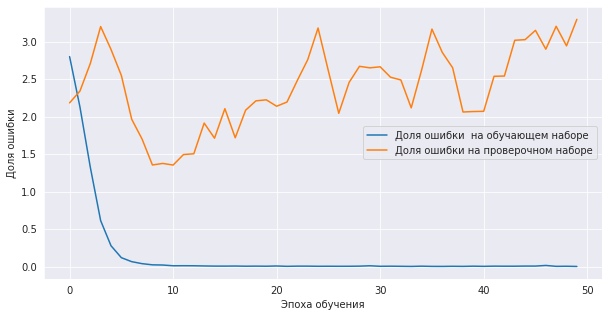

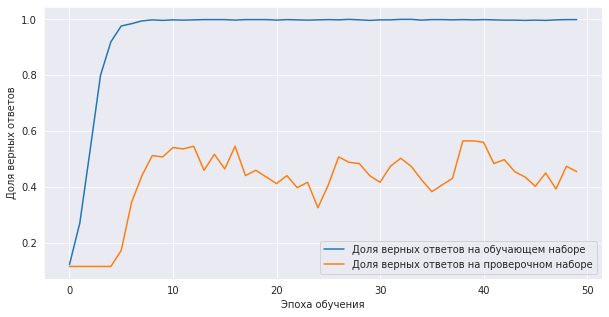

In [ ]:
# Выводим график
chart(history_model_Conv1D_20_5)

In [ ]:
# Посмотрим на результат на тестовой выборке
val, average = recognizeMultiClass(model_Conv1D_20_5, xTest9Classes, "BD_LSTM_4_True_LSTM_4")

Нейронная сеть:  BD_LSTM_4_True_LSTM_4

Аппендицит  распознано  50 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  61 % сеть считает, что это  Гастрит ,  распознано ВЕРНО!
Гепатит  распознано  100 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  50 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  28 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  18 % сеть считает, что это  Гепатит ,  распознано НЕ ВЕРНО!
Эзофагит  распознано  66 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  70 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  0 % сеть считает, что это  Гастрит ,  распознано НЕ ВЕРНО!

Средний процент распознавания  45 %


In [ ]:
# C помощью функции получаем значения на последней эпохе
result = table(history_model_Conv1D_20_5)    

In [ ]:
# Заносим результат в таблицу
df.loc['2.1 Conv1D'] = [round(result[0][-1],4), round(result[1][-1]*100, 4), round(result[2][-1],4), round(result[3][-1]*100,4),
                                          int(val[0]*100), int(val[1]*100), int(val[2]*100), int(val[3]*100), int(val[4]*100), int(val[5]*100), int(val[6]*100), int(val[7]*100), int(val[8]*100), average]

### 2.2 Embedding + Conv1D(20,5) + GlobalMaxPooling(GMP)

In [ ]:
model_Conv1D_20_5_GMP = Sequential() 

model_Conv1D_20_5_GMP.add(Embedding(maxWordsCount, 50, input_length=xLen))

model_Conv1D_20_5_GMP.add(SpatialDropout1D(0.2)) 
model_Conv1D_20_5_GMP.add(BatchNormalization())  

model_Conv1D_20_5_GMP.add(Conv1D(20, 5, activation="relu", padding='same')) 
model_Conv1D_20_5_GMP.add(Conv1D(20, 5, activation="relu", padding='same'))  
model_Conv1D_20_5_GMP.add(MaxPooling1D(2)) 
model_Conv1D_20_5_GMP.add(Dropout(0.2)) 
model_Conv1D_20_5_GMP.add(BatchNormalization()) 

model_Conv1D_20_5_GMP.add(GlobalMaxPooling1D())   # Добавим данный слой

model_Conv1D_20_5_GMP.add(Dense(20, activation="relu"))
model_Conv1D_20_5_GMP.add(Dropout(0.2)) 
model_Conv1D_20_5_GMP.add(BatchNormalization()) 

model_Conv1D_20_5_GMP.add(Dense(9, activation='softmax')) 


model_Conv1D_20_5_GMP.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#### Схема нейронной сети

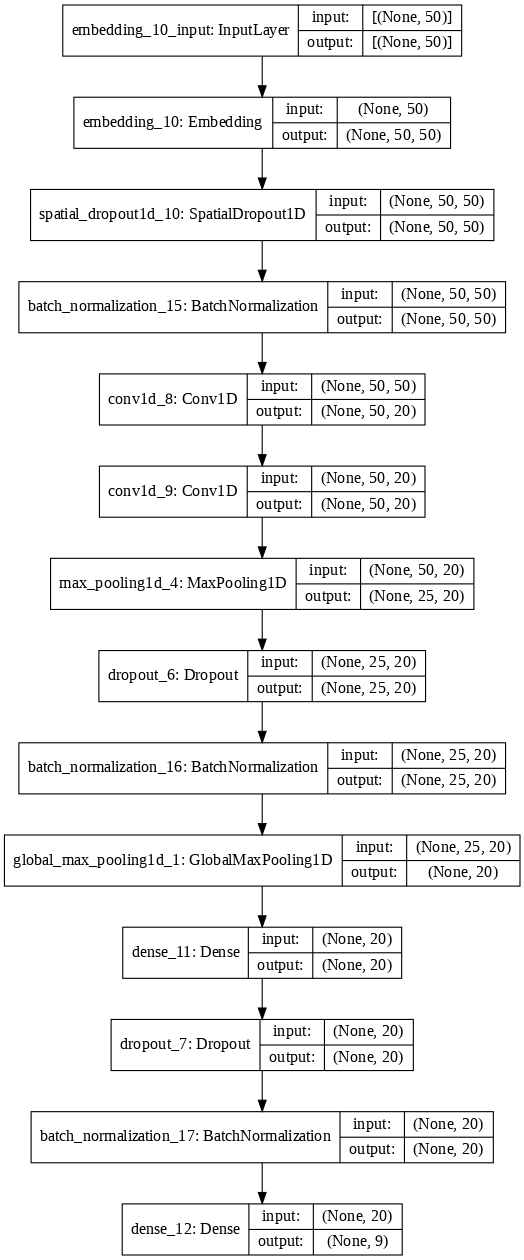

In [ ]:
showModel(model_Conv1D_20_5_GMP)

#### Обучение

In [ ]:
# Обучаем нейронную сеть
history_model_Conv1D_20_5_GMP = model_Conv1D_20_5_GMP.fit(xTrain, yTrain, epochs=50, batch_size=20, validation_data=(xTest, yTest))

Epoch 1/50
55/55 [==============================] - 2s 12ms/step - loss: 2.1709 - accuracy: 0.2386 - val_loss: 2.3511 - val_accuracy: 0.0957
Epoch 2/50
55/55 [==============================] - 0s 9ms/step - loss: 1.3131 - accuracy: 0.6011 - val_loss: 2.5160 - val_accuracy: 0.1005
Epoch 3/50
55/55 [==============================] - 0s 8ms/step - loss: 1.0065 - accuracy: 0.7481 - val_loss: 2.7243 - val_accuracy: 0.1005
Epoch 4/50
55/55 [==============================] - 0s 8ms/step - loss: 0.7357 - accuracy: 0.8379 - val_loss: 2.9062 - val_accuracy: 0.1005
Epoch 5/50
55/55 [==============================] - 0s 8ms/step - loss: 0.5972 - accuracy: 0.8800 - val_loss: 3.0059 - val_accuracy: 0.1005
Epoch 6/50
55/55 [==============================] - 0s 8ms/step - loss: 0.4915 - accuracy: 0.9123 - val_loss: 2.7913 - val_accuracy: 0.1005
Epoch 7/50
55/55 [==============================] - 0s 8ms/step - loss: 0.4308 - accuracy: 0.9109 - val_loss: 2.3390 - val_accuracy: 0.2344
Epoch 8/50
55/55 [=

In [ ]:
# Сохраняем веса
model_Conv1D_20_5_GMP.save_weights('model_Conv1D_20_5_GMP loss: 0.0634  - val_accuracy: 0.6651.h5')  

#### График и средний процент

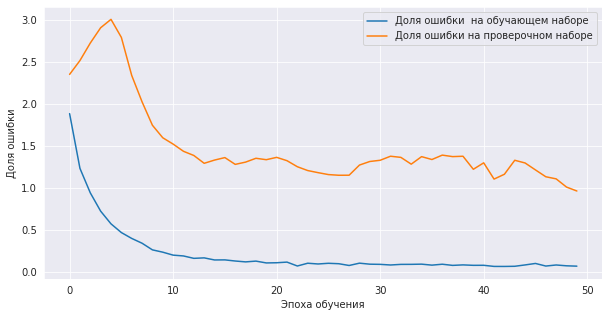

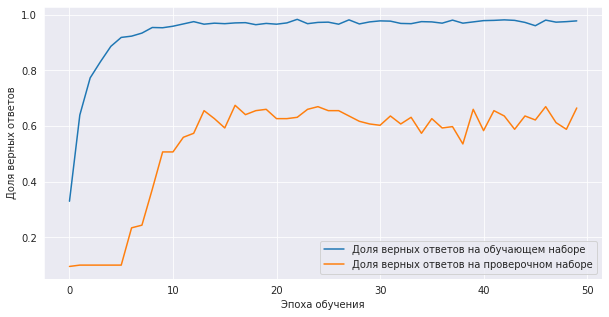

In [ ]:
# Выводим график
chart(history_model_Conv1D_20_5_GMP)

In [ ]:
# Посмотрим на результат на тестовой выборке
val, average = recognizeMultiClass(model_Conv1D_20_5_GMP, xTest9Classes, "modelLSTM_4")

Нейронная сеть:  modelLSTM_4

Аппендицит  распознано  0 % сеть считает, что это  Гепатит ,  распознано НЕ ВЕРНО!
Гастрит  распознано  50 % сеть считает, что это  Гастрит ,  распознано ВЕРНО!
Гепатит  распознано  47 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  70 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  97 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  70 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Эзофагит  распознано  38 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Энтерит  распознано  95 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  70 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  66 %


In [ ]:
# C помощью функции получаем значения на последней эпохе
result = table(history_model_Conv1D_20_5_GMP)    

In [ ]:
# Заносим результат в таблицу
df.loc['2.2 Conv1D'] = [round(result[0][-1],4), round(result[1][-1]*100, 4), round(result[2][-1],4), round(result[3][-1]*100,4),
                                          int(val[0]*100), int(val[1]*100), int(val[2]*100), int(val[3]*100), int(val[4]*100), int(val[5]*100), int(val[6]*100), int(val[7]*100), int(val[8]*100), average]

### 2.3 Embedding + Conv1D(20,5),Conv1D(20,5) - 3 раза

In [ ]:
model_Conv1D_Conv1D_Conv1D_20_5 = Sequential()

model_Conv1D_Conv1D_Conv1D_20_5.add(Embedding(maxWordsCount, 50, input_length=xLen))

model_Conv1D_Conv1D_Conv1D_20_5.add(SpatialDropout1D(0.5))
model_Conv1D_Conv1D_Conv1D_20_5.add(BatchNormalization())
model_Conv1D_Conv1D_Conv1D_20_5.add(Conv1D(20, 5, activation='relu', padding='same'))
model_Conv1D_Conv1D_Conv1D_20_5.add(Conv1D(20, 5, activation='relu', padding='same'))
model_Conv1D_Conv1D_Conv1D_20_5.add(MaxPooling1D(2))
model_Conv1D_Conv1D_Conv1D_20_5.add(Dropout(0.2))
model_Conv1D_Conv1D_Conv1D_20_5.add(BatchNormalization())

model_Conv1D_Conv1D_Conv1D_20_5.add(SpatialDropout1D(0.5))
model_Conv1D_Conv1D_Conv1D_20_5.add(BatchNormalization())
model_Conv1D_Conv1D_Conv1D_20_5.add(Conv1D(20, 5, activation='relu', padding='same'))
model_Conv1D_Conv1D_Conv1D_20_5.add(Conv1D(20, 5, activation='relu', padding='same'))
model_Conv1D_Conv1D_Conv1D_20_5.add(MaxPooling1D(2))
model_Conv1D_Conv1D_Conv1D_20_5.add(Dropout(0.2))
model_Conv1D_Conv1D_Conv1D_20_5.add(BatchNormalization())

model_Conv1D_Conv1D_Conv1D_20_5.add(SpatialDropout1D(0.5))
model_Conv1D_Conv1D_Conv1D_20_5.add(BatchNormalization())
model_Conv1D_Conv1D_Conv1D_20_5.add(Conv1D(20, 5, activation='relu', padding='same'))
model_Conv1D_Conv1D_Conv1D_20_5.add(Conv1D(20, 5, activation='relu', padding='same'))
model_Conv1D_Conv1D_Conv1D_20_5.add(MaxPooling1D(2))
model_Conv1D_Conv1D_Conv1D_20_5.add(Dropout(0.2))
model_Conv1D_Conv1D_Conv1D_20_5.add(BatchNormalization())

model_Conv1D_Conv1D_Conv1D_20_5.add(GlobalMaxPooling1D())

model_Conv1D_Conv1D_Conv1D_20_5.add(Flatten())

model_Conv1D_Conv1D_Conv1D_20_5.add(Dense(30, activation='relu'))
model_Conv1D_Conv1D_Conv1D_20_5.add(Dropout(0.2))
model_Conv1D_Conv1D_Conv1D_20_5.add(BatchNormalization())

model_Conv1D_Conv1D_Conv1D_20_5.add(Dense(9, activation='softmax'))


model_Conv1D_Conv1D_Conv1D_20_5.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#### Схема нейронной сети

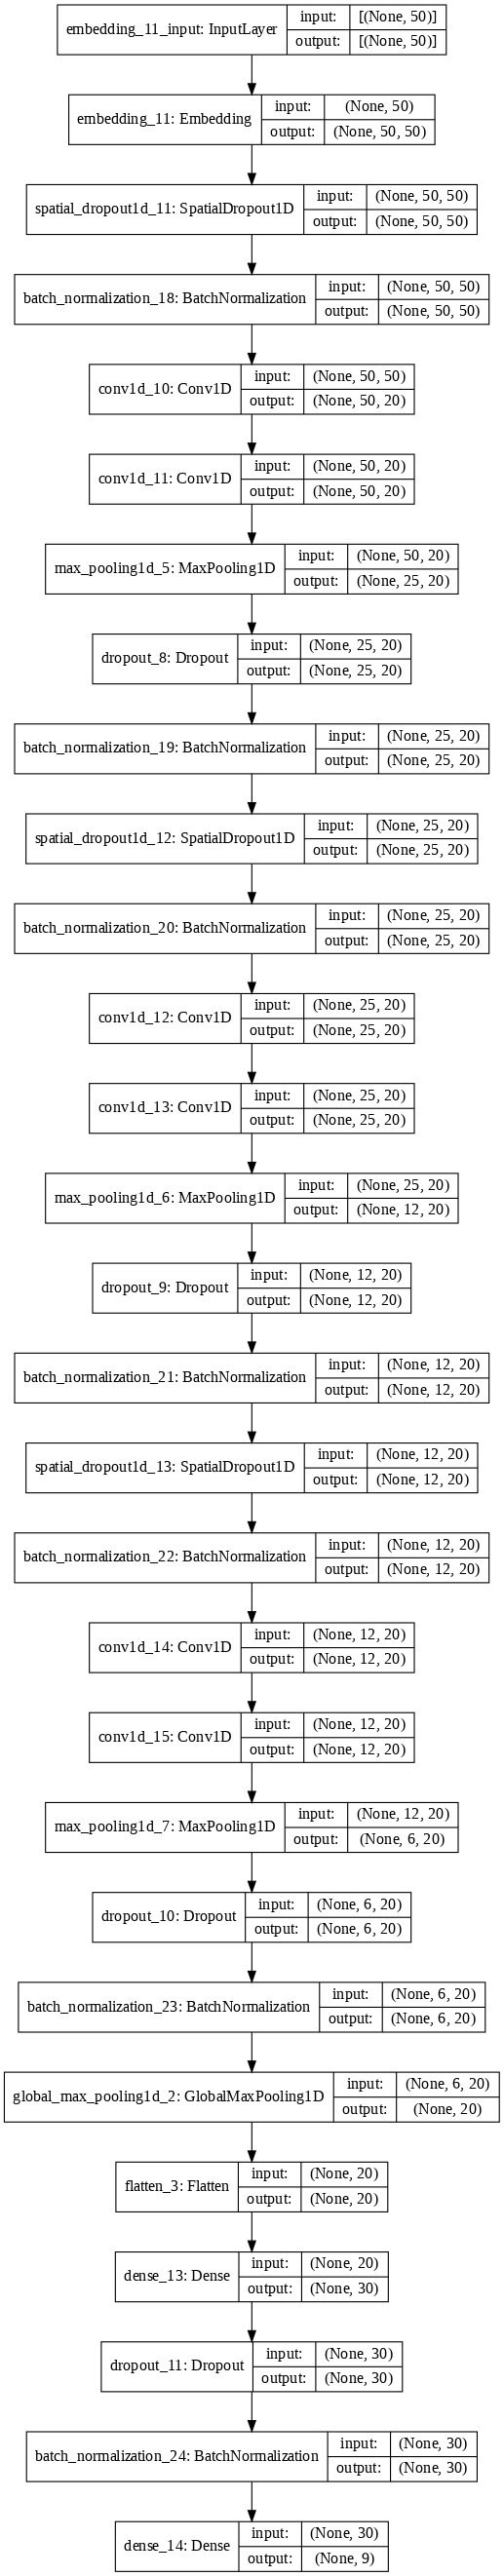

In [ ]:
showModel(model_Conv1D_Conv1D_Conv1D_20_5)

#### Обучение

In [ ]:
# Обучаем нейронную сеть
history_model_Conv1D_Conv1D_Conv1D_20_5 = model_Conv1D_Conv1D_Conv1D_20_5.fit(xTrain, yTrain, epochs=50, batch_size=20, validation_data=(xTest, yTest))

Epoch 1/50
55/55 [==============================] - 4s 20ms/step - loss: 2.6546 - accuracy: 0.1080 - val_loss: 2.2466 - val_accuracy: 0.0478
Epoch 2/50
55/55 [==============================] - 1s 12ms/step - loss: 2.5815 - accuracy: 0.1201 - val_loss: 2.3041 - val_accuracy: 0.0478
Epoch 3/50
55/55 [==============================] - 1s 12ms/step - loss: 2.3616 - accuracy: 0.1401 - val_loss: 2.3464 - val_accuracy: 0.0478
Epoch 4/50
55/55 [==============================] - 1s 13ms/step - loss: 2.3350 - accuracy: 0.1452 - val_loss: 2.3083 - val_accuracy: 0.0478
Epoch 5/50
55/55 [==============================] - 1s 12ms/step - loss: 2.3042 - accuracy: 0.1529 - val_loss: 2.2538 - val_accuracy: 0.0478
Epoch 6/50
55/55 [==============================] - 1s 13ms/step - loss: 2.2807 - accuracy: 0.1496 - val_loss: 2.3270 - val_accuracy: 0.0478
Epoch 7/50
55/55 [==============================] - 1s 13ms/step - loss: 2.2339 - accuracy: 0.1863 - val_loss: 2.2139 - val_accuracy: 0.0574
Epoch 8/50
55

In [ ]:
# Сохраняем веса
model_Conv1D_Conv1D_Conv1D_20_5.save_weights('history_model_Conv1D_20_5 loss: 0.7598  - val_accuracy: 0.2105.h5')   

#### График и средний процент

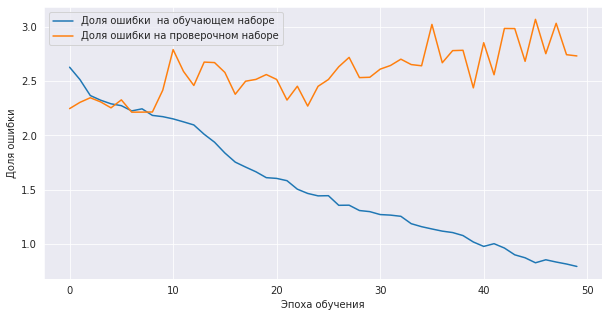

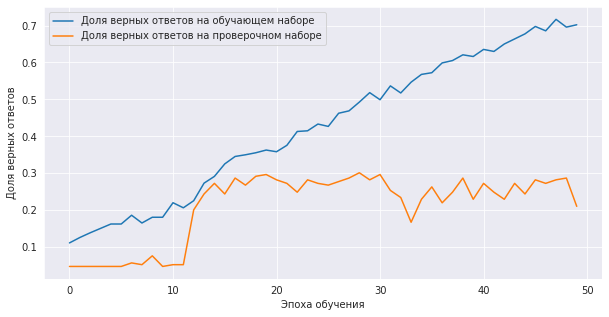

In [ ]:
# Выводим график
chart(history_model_Conv1D_Conv1D_Conv1D_20_5)

In [ ]:
# Посмотрим на результат на тестовой выборке
val, average = recognizeMultiClass(model_Conv1D_Conv1D_Conv1D_20_5, xTest9Classes, "modelLSTM_4")

Нейронная сеть:  modelLSTM_4

Аппендицит  распознано  0 % сеть считает, что это  Гепатит ,  распознано НЕ ВЕРНО!
Гастрит  распознано  3 % сеть считает, что это  Гепатит ,  распознано НЕ ВЕРНО!
Гепатит  распознано  0 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Дуоденит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Колит  распознано  5 % сеть считает, что это  Эзофагит ,  распознано НЕ ВЕРНО!
Панкреатит  распознано  64 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Эзофагит  распознано  33 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Энтерит  распознано  8 % сеть считает, что это  Гастрит ,  распознано НЕ ВЕРНО!
Язва  распознано  0 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!

Средний процент распознавания  21 %


In [ ]:
# C помощью функции получаем значения на последней эпохе
result = table(history_model_Conv1D_Conv1D_Conv1D_20_5)    

In [ ]:
# Заносим результат в таблицу
df.loc['2.3 Conv1D'] = [round(result[0][-1],4), round(result[1][-1]*100, 4), round(result[2][-1],4), round(result[3][-1]*100,4),
                                          int(val[0]*100), int(val[1]*100), int(val[2]*100), int(val[3]*100), int(val[4]*100), int(val[5]*100), int(val[6]*100), int(val[7]*100), int(val[8]*100), average]

## 3. Серия экспериментов Embedding + сложная сеть из Dense, LSTM и Conv1D.


### Embedding + сложная сеть из Dense, LSTM и Conv1D

#### 3.1 Embedding + Dense, LSTM и Conv1D

In [ ]:
model_D_100_L_4_C_2 = Sequential() 

model_D_100_L_4_C_2.add(Embedding(maxWordsCount, 50, input_length=xLen))
model_D_100_L_4_C_2.add(Dropout(0.4)) 
model_D_100_L_4_C_2.add(SpatialDropout1D(0.2)) 

model_D_100_L_4_C_2.add(LSTM(4, return_sequences=1)) 

model_D_100_L_4_C_2.add(Dense(100, activation='relu')) 

model_D_100_L_4_C_2.add(Conv1D(20, 5, activation="relu")) 

model_D_100_L_4_C_2.add(LSTM(4, return_sequences=1)) 
model_D_100_L_4_C_2.add(Dropout(0.4)) 
model_D_100_L_4_C_2.add(BatchNormalization()) 

model_D_100_L_4_C_2.add(Conv1D(20, 5, activation="relu"))  
model_D_100_L_4_C_2.add(Conv1D(20, 5, activation="relu")) 

model_D_100_L_4_C_2.add(MaxPooling1D(2)) 
model_D_100_L_4_C_2.add(Dropout(0.4)) 
model_D_100_L_4_C_2.add(BatchNormalization()) 

model_D_100_L_4_C_2.add(Flatten()) 
model_D_100_L_4_C_2.add(Dense(9, activation='softmax')) 

model_D_100_L_4_C_2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

##### Схема нейронной сети

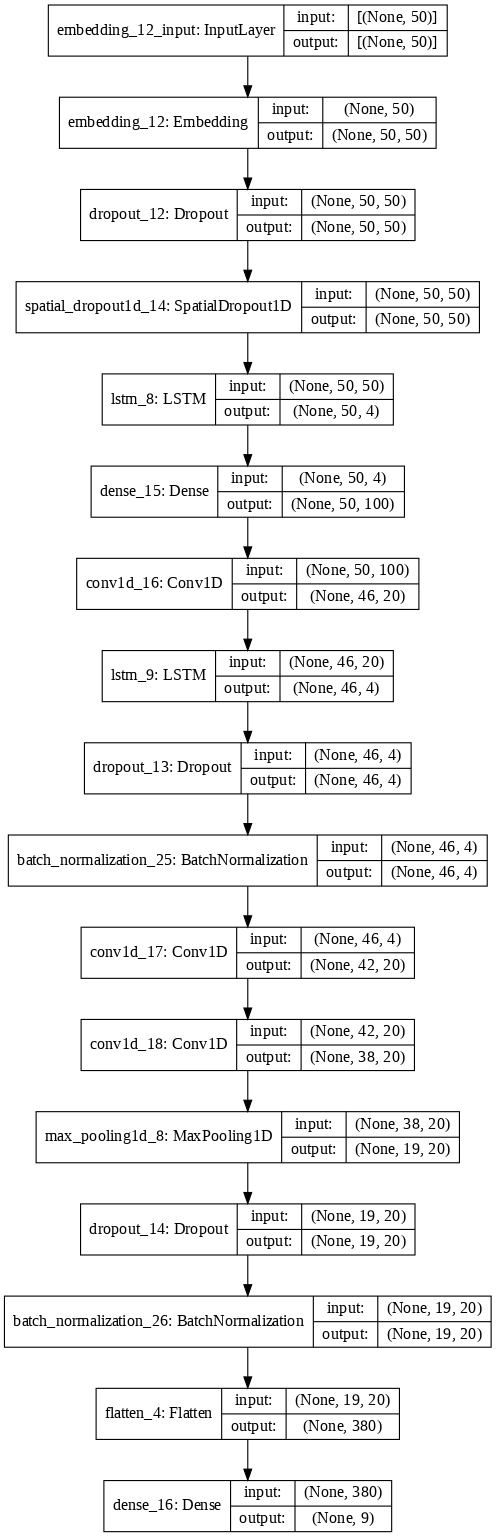

In [ ]:
showModel(model_D_100_L_4_C_2)

##### Обучение

In [ ]:
# Обучаем нейронную сеть
history_model_D_100_L_4_C_2 = model_D_100_L_4_C_2.fit(xTrain, yTrain, epochs = 50, batch_size=20, validation_data=(xTest, yTest))

Epoch 1/50
55/55 [==============================] - 5s 27ms/step - loss: 2.6835 - accuracy: 0.1086 - val_loss: 2.1500 - val_accuracy: 0.2392
Epoch 2/50
55/55 [==============================] - 1s 14ms/step - loss: 2.1285 - accuracy: 0.1692 - val_loss: 2.0961 - val_accuracy: 0.2392
Epoch 3/50
55/55 [==============================] - 1s 14ms/step - loss: 1.7224 - accuracy: 0.3583 - val_loss: 2.1143 - val_accuracy: 0.2392
Epoch 4/50
55/55 [==============================] - 1s 14ms/step - loss: 1.2919 - accuracy: 0.5212 - val_loss: 2.1766 - val_accuracy: 0.2392
Epoch 5/50
55/55 [==============================] - 1s 14ms/step - loss: 0.9019 - accuracy: 0.6597 - val_loss: 2.3229 - val_accuracy: 0.1244
Epoch 6/50
55/55 [==============================] - 1s 14ms/step - loss: 0.7394 - accuracy: 0.7226 - val_loss: 2.5766 - val_accuracy: 0.1148
Epoch 7/50
55/55 [==============================] - 1s 14ms/step - loss: 0.5303 - accuracy: 0.7729 - val_loss: 2.8446 - val_accuracy: 0.0574
Epoch 8/50
55

In [ ]:
# Сохраняем веса
model_D_100_L_4_C_2.save_weights('model_D_100_L_4_C_2 loss: 0.0427   - val_accuracy: 0.2632.h5')   

##### График и средний процент

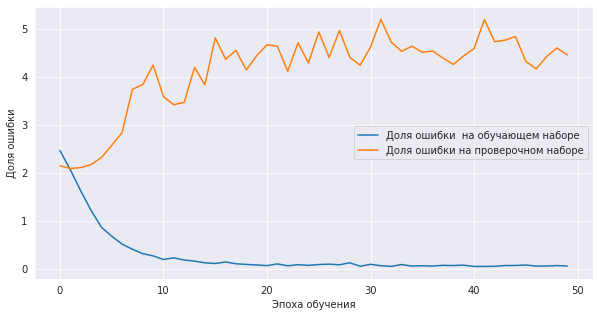

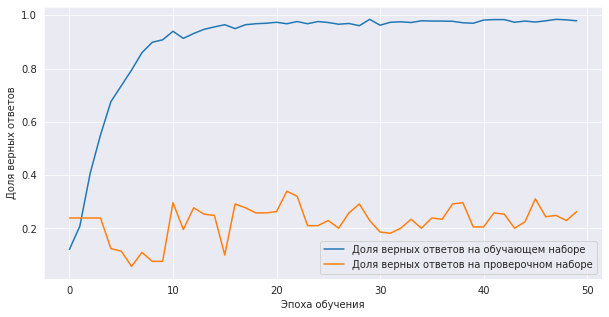

In [ ]:
# Выводим график
chart(history_model_D_100_L_4_C_2)

In [ ]:
# Посмотрим на результат на тестовой выборке
val, average = recognizeMultiClass(model_D_100_L_4_C_2, xTest9Classes, "BD_LSTM_4_True_LSTM_4")

Нейронная сеть:  BD_LSTM_4_True_LSTM_4

Аппендицит  распознано  50 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Гепатит  распознано  23 % сеть считает, что это  Дуоденит ,  распознано НЕ ВЕРНО!
Дуоденит  распознано  50 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  74 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Эзофагит  распознано  0 % сеть считает, что это  Колит ,  распознано НЕ ВЕРНО!
Энтерит  распознано  16 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Язва  распознано  70 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  26 %


In [ ]:
# C помощью функции получаем значения на последней эпохе
result = table(history_model_D_100_L_4_C_2)    

In [ ]:
# Заносим результат в таблицу
df.loc['3.1 Сложная сеть Dense,LSTM,Conv1D'] = [round(result[0][-1],4), round(result[1][-1]*100, 4), round(result[2][-1],4), round(result[3][-1]*100,4),
                                          int(val[0]*100), int(val[1]*100), int(val[2]*100), int(val[3]*100), int(val[4]*100), int(val[5]*100), int(val[6]*100), int(val[7]*100), int(val[8]*100), average]

#### 3.2  Изменим гиперпараметры сети Embedding + Dense, LSTM и Conv1D

In [ ]:
model_D_50_L_20_C_50 = Sequential() 

model_D_50_L_20_C_50.add(Embedding(maxWordsCount, 50, input_length=xLen))
model_D_50_L_20_C_50.add(Dropout(0.4)) 
model_D_50_L_20_C_50.add(SpatialDropout1D(0.2)) 

model_D_50_L_20_C_50.add(LSTM(20, return_sequences=1)) 

model_D_50_L_20_C_50.add(Dense(50, activation='relu')) 

model_D_50_L_20_C_50.add(Conv1D(50, 5, activation="relu")) 

model_D_50_L_20_C_50.add(LSTM(20, return_sequences=1)) 
model_D_50_L_20_C_50.add(Dropout(0.4)) 
model_D_50_L_20_C_50.add(BatchNormalization()) 

model_D_50_L_20_C_50.add(Conv1D(50, 5, activation="relu"))  
model_D_50_L_20_C_50.add(Conv1D(50, 5, activation="relu")) 

model_D_50_L_20_C_50.add(MaxPooling1D(2)) 
model_D_50_L_20_C_50.add(Dropout(0.4)) 
model_D_50_L_20_C_50.add(BatchNormalization()) 

model_D_50_L_20_C_50.add(Flatten()) 
model_D_50_L_20_C_50.add(Dense(9, activation='softmax')) 

model_D_50_L_20_C_50.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

##### Схема нейронной сети

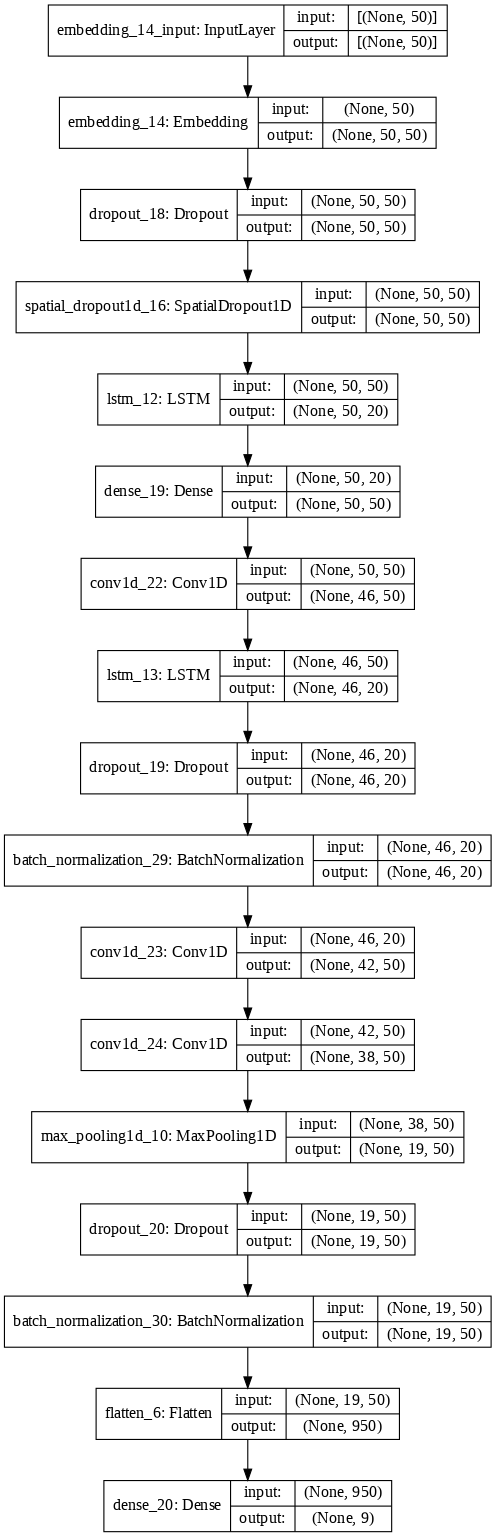

In [ ]:
showModel(model_D_50_L_20_C_50)

##### Обучение

In [ ]:
# Обучаем нейронную сеть
history_model_D_50_L_20_C_50 = model_D_50_L_20_C_50.fit(xTrain, yTrain, epochs = 50, batch_size=20, validation_data=(xTest, yTest))

Epoch 1/50
55/55 [==============================] - 5s 31ms/step - loss: 2.7566 - accuracy: 0.1282 - val_loss: 2.1797 - val_accuracy: 0.2392
Epoch 2/50
55/55 [==============================] - 1s 14ms/step - loss: 1.6490 - accuracy: 0.4154 - val_loss: 2.4800 - val_accuracy: 0.0574
Epoch 3/50
55/55 [==============================] - 1s 15ms/step - loss: 0.9353 - accuracy: 0.6710 - val_loss: 3.1159 - val_accuracy: 0.0478
Epoch 4/50
55/55 [==============================] - 1s 15ms/step - loss: 0.4452 - accuracy: 0.8467 - val_loss: 4.5768 - val_accuracy: 0.0478
Epoch 5/50
55/55 [==============================] - 1s 14ms/step - loss: 0.2571 - accuracy: 0.9268 - val_loss: 5.2066 - val_accuracy: 0.0478
Epoch 6/50
55/55 [==============================] - 1s 15ms/step - loss: 0.1465 - accuracy: 0.9454 - val_loss: 5.6544 - val_accuracy: 0.0478
Epoch 7/50
55/55 [==============================] - 1s 15ms/step - loss: 0.1225 - accuracy: 0.9682 - val_loss: 5.2477 - val_accuracy: 0.0718
Epoch 8/50
55

In [ ]:
# Сохраняем веса
model_D_50_L_20_C_50.save_weights('model_D_50_L_20_C_50 loss: 0.0304 - val_accuracy: 0.5550.h5')   

##### График и средний процент

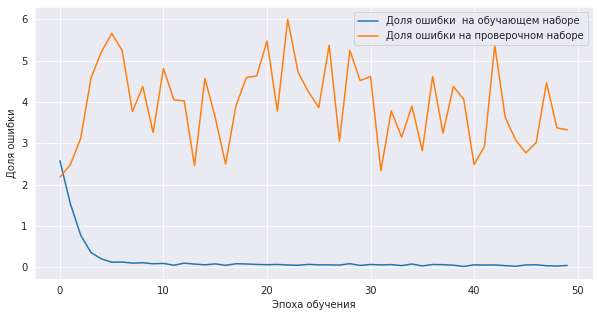

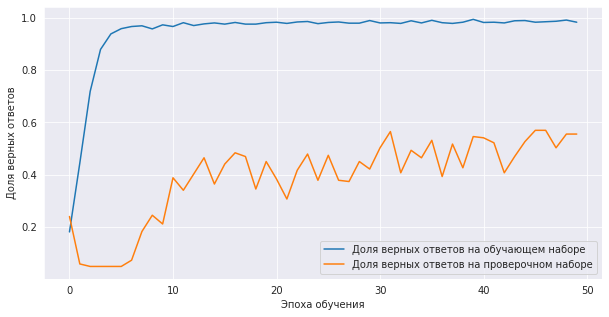

In [ ]:
# Выводим график
chart(history_model_D_50_L_20_C_50)

In [ ]:
# Посмотрим на результат на тестовой выборке
val, average = recognizeMultiClass(model_D_50_L_20_C_50, xTest9Classes, "BD_LSTM_4_True_LSTM_4")

Нейронная сеть:  BD_LSTM_4_True_LSTM_4

Аппендицит  распознано  75 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  0 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Гепатит  распознано  70 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  30 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Колит  распознано  87 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  64 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Эзофагит  распознано  28 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Энтерит  распознано  83 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  0 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!

Средний процент распознавания  55 %


In [ ]:
# C помощью функции получаем значения на последней эпохе
result = table(history_model_D_50_L_20_C_50)    

In [ ]:
# Заносим результат в таблицу
df.loc['3.2 Сложная сеть Dense,LSTM,Conv1D'] = [round(result[0][-1],4), round(result[1][-1]*100, 4), round(result[2][-1],4), round(result[3][-1]*100,4),
                                          int(val[0]*100), int(val[1]*100), int(val[2]*100), int(val[3]*100), int(val[4]*100), int(val[5]*100), int(val[6]*100), int(val[7]*100), int(val[8]*100), average]

## Результат экспериментов 

In [ ]:
# Посмотрим на таблицу
df

,loss,accuracy,val_loss,val_accuracy,Аппендицит,Гастрит,Гепатит,Дуоденит,Колит,Панкреатит,Эзофагит,Энтерит,Язва,Средний процент распознавания
1.1 LSTM,0.2211,94.6069,1.5778,63.6364,91.0,0.0,94.0,30.0,89.0,66.0,66.0,87.0,0.0,63.0
1.2 LSTM,0.0357,99.4516,2.5582,53.1100,100.0,11.0,82.0,40.0,97.0,8.0,57.0,100.0,0.0,53.0
1.3 LSTM,0.3166,93.7843,2.4991,42.1053,0.0,19.0,88.0,100.0,41.0,24.0,66.0,66.0,0.0,42.0
1.4 LSTM,0.1778,95.0640,2.3378,46.8900,83.0,19.0,5.0,50.0,84.0,22.0,66.0,79.0,0.0,46.0
2.1 Conv1D,0.0023,99.9086,3.2963,45.4545,50.0,61.0,100.0,50.0,28.0,18.0,66.0,70.0,0.0,45.0
2.2 Conv1D,0.0704,97.8062,0.9643,66.5072,0.0,50.0,47.0,70.0,97.0,70.0,38.0,95.0,70.0,66.0
2.3 Conv1D,0.7957,70.2011,2.7308,21.0526,0.0,3.0,0.0,0.0,5.0,64.0,33.0,8.0,0.0,21.0
"3.1 Сложная сеть Dense,LSTM,Conv1D",0.0613,97.8976,4.4638,26.3158,50.0,0.0,23.0,50.0,74.0,0.0,0.0,16.0,70.0,26.0
"3.2 Сложная сеть Dense,LSTM,Conv1D",0.0426,98.3547,3.3239,55.5024,75.0,0.0,70.0,30.0,87.0,64.0,28.0,83.0,0.0,55.0


## 4. BOW

В задании такого нет, но ради интереса посмотрим как с данным заданием справится **Bag of Words**

In [ ]:
# Для этого нужно преобразовывать в матрицу
xTrainBOW = tokenizer.sequences_to_matrix(xTrain.tolist())      
xTestBOW = tokenizer.sequences_to_matrix(xTest.tolist())      

# Посмотрим на размер
print (xTrainBOW.shape)
print (xTestBOW.shape)

(1094, 10000)
(209, 10000)


### 4.1 BoW + Dense(300)

In [ ]:
# Создадим полносвязную сеть
model_BOW_300 = Sequential()
model_BOW_300.add(Dense(300, input_dim=maxWordsCount, activation='relu'))
model_BOW_300.add(Dropout(0.4))
model_BOW_300.add(BatchNormalization())
model_BOW_300.add(Dense(9, activation='softmax'))

model_BOW_300.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Схема нейронной сети

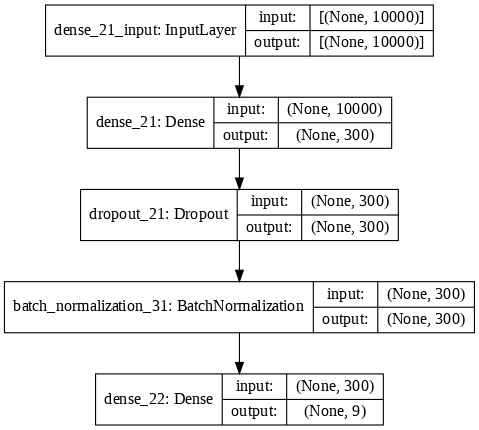

In [ ]:
showModel(model_BOW_300)

#### Обучение

In [ ]:
# Обучаем нейронную сеть
history_model_BOW_300 = model_BOW_300.fit(xTrainBOW, yTrain, epochs = 50, batch_size=20, validation_data=(xTestBOW, yTest))

Epoch 1/50
55/55 [==============================] - 1s 7ms/step - loss: 0.8644 - accuracy: 0.7321 - val_loss: 1.7123 - val_accuracy: 0.7560
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 1.5419 - val_accuracy: 0.7703
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.3764 - val_accuracy: 0.7799
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.2015 - val_accuracy: 0.7847
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.0605 - val_accuracy: 0.7751
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.9368 - val_accuracy: 0.7799
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 9.7482e-04 - accuracy: 1.0000 - val_loss: 0.8571 - val_accuracy: 0.7799
Epoch 8/50
55/55

In [ ]:
# Сохраняем веса
model_BOW_300.save_weights('model_BOW_300 loss: 6.3473e-05 - val_accuracy: 0.7751.h5')   

#### График и средний процент

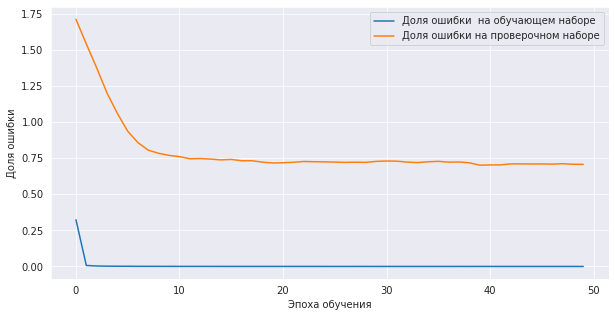

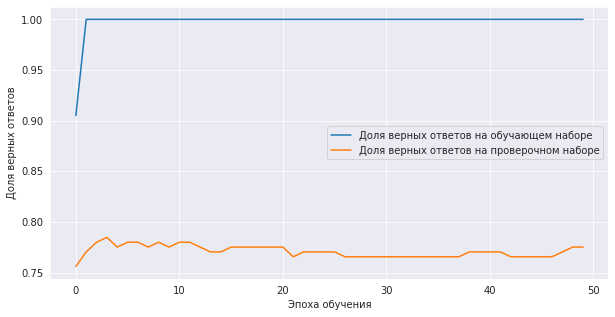

In [ ]:
# Выводим график
chart(history_model_BOW_300)

In [ ]:
# Посмотрим на результат на тестовой выборке
val, average = recognizeMultiClass(model_BOW_300, xTest9ClassesBow, "model_BOW_300")

Нейронная сеть:  model_BOW_300

Аппендицит  распознано  100 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  30 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Гепатит  распознано  82 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  70 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  100 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  74 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Эзофагит  распознано  100 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  100 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  0 % сеть считает, что это  Эзофагит ,  распознано НЕ ВЕРНО!

Средний процент распознавания  77 %


In [ ]:
# C помощью функции получаем значения на последней эпохе
result = table(history_model_BOW_300)    

In [ ]:
# Заносим результат в таблицу
df.loc['4.1 BoW'] = [round(result[0][-1],4), round(result[1][-1]*100, 4), round(result[2][-1],4), round(result[3][-1]*100,4),
                                          int(val[0]*100), int(val[1]*100), int(val[2]*100), int(val[3]*100), int(val[4]*100), int(val[5]*100), int(val[6]*100), int(val[7]*100), int(val[8]*100), average]

### 4.2 BoW + Dense(200) + Dense(100)

In [ ]:
# Создадим полносвязную сеть
model_BOW_200_100 = Sequential()
model_BOW_200_100.add(Dense(200, input_dim=maxWordsCount, activation='relu'))
model_BOW_200_100.add(Dropout(0.3))
model_BOW_200_100.add(BatchNormalization())

model_BOW_200_100.add(Dense(100, activation='relu'))
model_BOW_200_100.add(Dropout(0.3))
model_BOW_200_100.add(BatchNormalization())


model_BOW_200_100.add(Dense(9, activation='softmax'))

model_BOW_200_100.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Схема нейронной сети

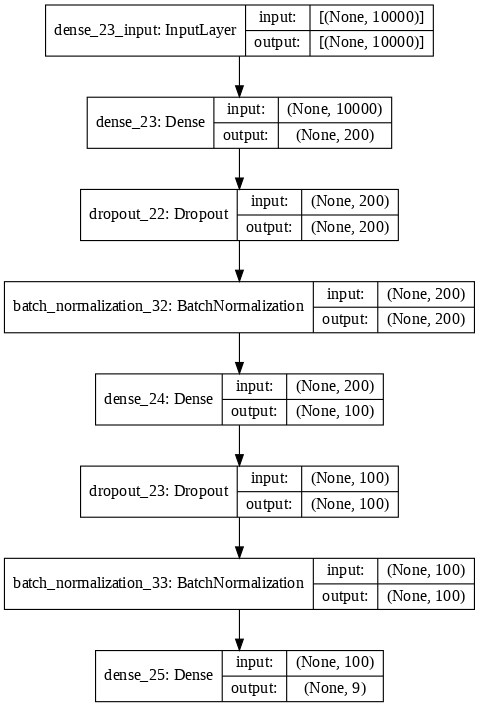

In [ ]:
showModel(model_BOW_200_100)

#### Обучение

In [ ]:
# Обучаем нейронную сеть
history_model_BOW_200_100 = model_BOW_200_100.fit(xTrainBOW, yTrain, epochs = 50, batch_size=20, validation_data=(xTestBOW, yTest))

Epoch 1/50
55/55 [==============================] - 1s 8ms/step - loss: 1.4580 - accuracy: 0.5556 - val_loss: 1.8659 - val_accuracy: 0.6029
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.1555 - accuracy: 0.9905 - val_loss: 1.6514 - val_accuracy: 0.6124
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.0614 - accuracy: 1.0000 - val_loss: 1.4860 - val_accuracy: 0.6555
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.0475 - accuracy: 0.9986 - val_loss: 1.2820 - val_accuracy: 0.7273
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.0277 - accuracy: 0.9994 - val_loss: 1.0955 - val_accuracy: 0.7703
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.0259 - accuracy: 1.0000 - val_loss: 0.9676 - val_accuracy: 0.8038
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.0186 - accuracy: 0.9993 - val_loss: 0.8880 - val_accuracy: 0.8038
Epoch 8/50
55/55 [==

In [ ]:
# Сохраняем веса
model_BOW_200_100.save_weights('model_BOW_200_100 loss: 0.0011 - val_accuracy: 0.71299.h5')   

#### График и средний процент

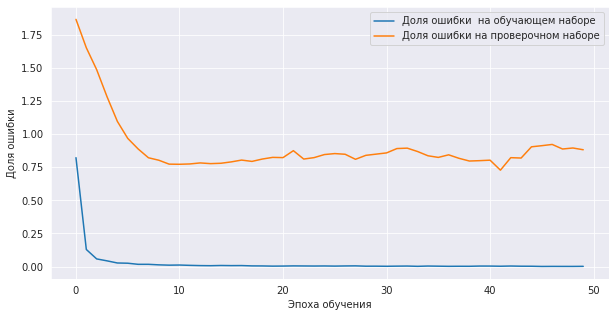

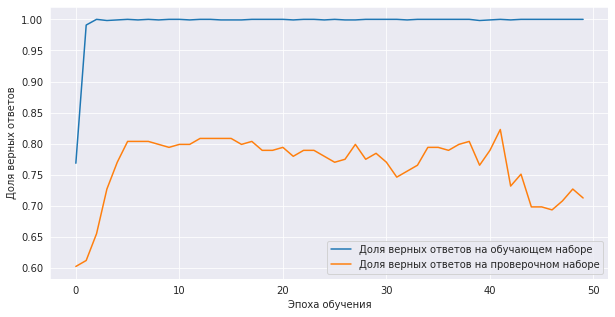

In [ ]:
# Выводим график
chart(history_model_BOW_200_100)

In [ ]:
# Посмотрим на результат на тестовой выборке
val, average = recognizeMultiClass(model_BOW_200_100, xTest9ClassesBow, "model_BOW_200_100")

Нейронная сеть:  model_BOW_200_100

Аппендицит  распознано  100 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  11 % сеть считает, что это  Эзофагит ,  распознано НЕ ВЕРНО!
Гепатит  распознано  94 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  80 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  100 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  52 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Эзофагит  распознано  100 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  100 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  0 % сеть считает, что это  Эзофагит ,  распознано НЕ ВЕРНО!

Средний процент распознавания  71 %


In [ ]:
# C помощью функции получаем значения на последней эпохе
result = table(history_model_BOW_200_100)    

In [ ]:
# Заносим результат в таблицу
df.loc['4.2 BoW'] = [round(result[0][-1],4), round(result[1][-1]*100, 4), round(result[2][-1],4), round(result[3][-1]*100,4),
                                          int(val[0]*100), int(val[1]*100), int(val[2]*100), int(val[3]*100), int(val[4]*100), int(val[5]*100), int(val[6]*100), int(val[7]*100), int(val[8]*100), average]

# Cравнительная таблица

In [ ]:
df

,loss,accuracy,val_loss,val_accuracy,Аппендицит,Гастрит,Гепатит,Дуоденит,Колит,Панкреатит,Эзофагит,Энтерит,Язва,Средний процент распознавания
1.1 LSTM,0.2211,94.6069,1.5778,63.6364,91.0,0.0,94.0,30.0,89.0,66.0,66.0,87.0,0.0,63.0
1.2 LSTM,0.0357,99.4516,2.5582,53.1100,100.0,11.0,82.0,40.0,97.0,8.0,57.0,100.0,0.0,53.0
1.3 LSTM,0.3166,93.7843,2.4991,42.1053,0.0,19.0,88.0,100.0,41.0,24.0,66.0,66.0,0.0,42.0
1.4 LSTM,0.1778,95.0640,2.3378,46.8900,83.0,19.0,5.0,50.0,84.0,22.0,66.0,79.0,0.0,46.0
2.1 Conv1D,0.0023,99.9086,3.2963,45.4545,50.0,61.0,100.0,50.0,28.0,18.0,66.0,70.0,0.0,45.0
2.2 Conv1D,0.0704,97.8062,0.9643,66.5072,0.0,50.0,47.0,70.0,97.0,70.0,38.0,95.0,70.0,66.0
2.3 Conv1D,0.7957,70.2011,2.7308,21.0526,0.0,3.0,0.0,0.0,5.0,64.0,33.0,8.0,0.0,21.0
"3.1 Сложная сеть Dense,LSTM,Conv1D",0.0613,97.8976,4.4638,26.3158,50.0,0.0,23.0,50.0,74.0,0.0,0.0,16.0,70.0,26.0
"3.2 Сложная сеть Dense,LSTM,Conv1D",0.0426,98.3547,3.3239,55.5024,75.0,0.0,70.0,30.0,87.0,64.0,28.0,83.0,0.0,55.0
4.1 BoW,0.0001,100.0000,0.7073,77.5120,100.0,30.0,82.0,70.0,100.0,74.0,100.0,100.0,0.0,77.0


In [ ]:
print('5 лучших результата по максимальной точности тестовой выборки')
df.sort_values('val_accuracy', ascending=False).head(5)

5 лучших результата по максимальной точности тестовой выборки


,loss,accuracy,val_loss,val_accuracy,Аппендицит,Гастрит,Гепатит,Дуоденит,Колит,Панкреатит,Эзофагит,Энтерит,Язва,Средний процент распознавания
4.1 BoW,0.0001,100.0000,0.7073,77.5120,100.0,30.0,82.0,70.0,100.0,74.0,100.0,100.0,0.0,77.0
4.2 BoW,0.0016,100.0000,0.8816,71.2919,100.0,11.0,94.0,80.0,100.0,52.0,100.0,100.0,0.0,71.0
2.2 Conv1D,0.0704,97.8062,0.9643,66.5072,0.0,50.0,47.0,70.0,97.0,70.0,38.0,95.0,70.0,66.0
1.1 LSTM,0.2211,94.6069,1.5778,63.6364,91.0,0.0,94.0,30.0,89.0,66.0,66.0,87.0,0.0,63.0
"3.2 Сложная сеть Dense,LSTM,Conv1D",0.0426,98.3547,3.3239,55.5024,75.0,0.0,70.0,30.0,87.0,64.0,28.0,83.0,0.0,55.0


# Выводы:

1. Цель домашнего задания: Для наилучшего результата требуется проверять множество гипотиз и разных архитектур нейронных сетей. 
2. Не всегда усложнение архитектуры приводит к увеличению точности нейронной сети. Как видно из таблицы сложные сети дают результат хуже, чем более простые.
3. Данные показатели разных гипотиз можно считать приближенными. Для более точных нужно запускать каждую нейронную сеть хотя бы раз 10 и смотреть средний результат, так как в начале веса инициализируются случайным образом.
4. Очень полезно выводить схему нейронной сети (чтобы увидеть что подается на вход и что получается с выхода каждого слоя.
   А так же графики  обучения (на которых можно увидеть переобучение или наоброт, что нейронную сеть можно обучать еще дальше)
5. Более простые решения могут показать лучший результат, как например с Bag of Words. 
6. Результат так же зависит и от обучающей выборки и собранной базы. Например при работе с болезнями некоторые симптомы пересекаются и один и тот же симптом может гооврить о разных болезнях. Что усложняет работу нейронной сети.
6. Данную работу было интересно проводить, так как требовалось не только разделить текст, но и подобрать оптимальные гиперпараметры. 
7. Так же изменение максимального числа индексов при токенизации, а так же таких парметров как ширина окна и шаг тоже влияют на обучение. 
8. Было перепробовано много разных вариантов.
9. Добавление таких слоев как Dropout(c разными значениями), BatchNormalization влияют на результат работы. 
10. Данное выволнение домашнего задания помогает понять как различная архитектура, а так же значения гиперпараметров влияют на результат работы нейронной сети в целом. 
11. Весь код набирался вручную, потому что так идет лучшие запоминание и понимание материала. 